In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from scipy.interpolate import splprep, splev
from scipy.signal import savgol_filter
from collections import defaultdict
from shapely.affinity import translate
from utils.gdf_visualize_utils import visualize_links_with_ref_lines, visualize_road_groups_with_reference_lines, visualize_road_groups
pixel_resolution = (dx, dy) = (0.125, -0.125)  # degrees per pixel (x: lon, y: lat)
# seems the shift is not right
lanes_and_links_gdf = gpd.read_file("lane_links_test_non_intersection.geojson")

In [2]:
def densify(line, interval=1.0):
    n = int(line.length / interval)
    return LineString([line.interpolate(i * interval) for i in range(n + 1)])

def resample_linestring(line: LineString, spacing=0.5, smoothing=0.001):
    coords = np.array(line.coords)
    if len(coords) < 3:
        return line  # too short to refine

    # Compute arc-length parameterization
    dists = np.cumsum(np.r_[0, np.linalg.norm(np.diff(coords, axis=0), axis=1)])
    total_length = dists[-1]
    t = dists / total_length

    # Fit B-spline (low smoothing)
    try:
        tck, _ = splprep([coords[:, 0], coords[:, 1]], u=t, s=smoothing)
    except ValueError:
        return line

    # Generate resampled distances, excluding 0 and total_length
    num_pts = max(int(total_length // spacing), 1)
    mid_dists = np.linspace(spacing, total_length - spacing, num_pts - 1)
    mid_t = mid_dists / total_length

    # Evaluate spline
    x_mid, y_mid = splev(mid_t, tck)

    # Combine with endpoints
    new_coords = [tuple(coords[0])] + list(zip(x_mid, y_mid)) + [tuple(coords[-1])]
    return LineString(new_coords)


lanes_and_links_original = lanes_and_links_gdf.copy()
lanes_and_links_refined = lanes_and_links_gdf.copy()

# Densify before spline
lanes_and_links_refined['geometry'] = lanes_and_links_refined['geometry'].apply(lambda l: densify(l, interval=1.0))

# Resample using low-smoothing spline
lanes_and_links_refined['geometry'] = lanes_and_links_refined['geometry'].apply(lambda l: resample_linestring(l, spacing=0.5, smoothing=1000))


Text(0.5, 1.0, 'Refined Lanes and Links')

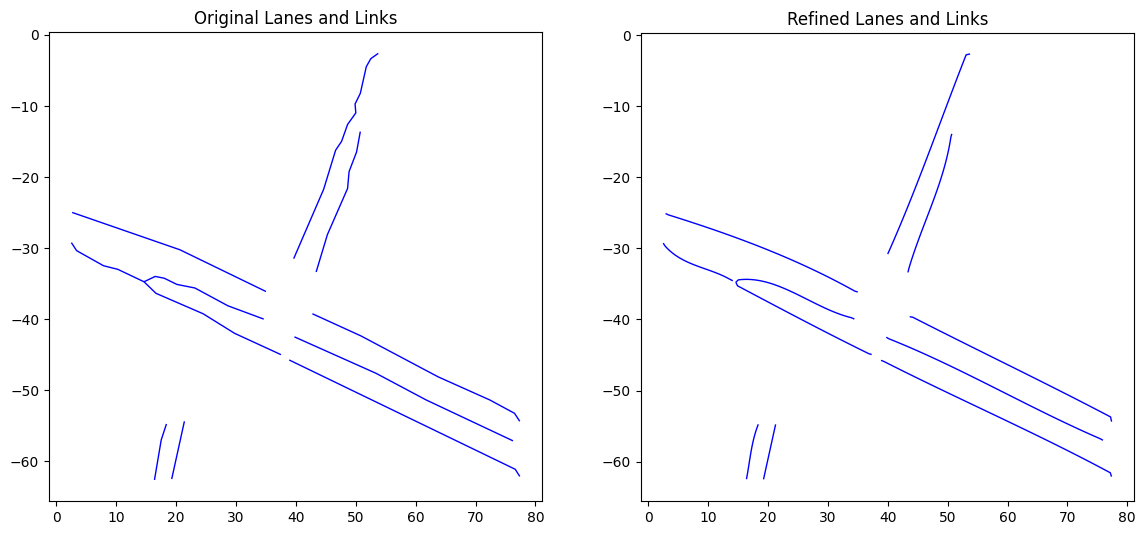

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

lanes_and_links_original[lanes_and_links_gdf['type'] == 'lane'].plot(ax=axs[0], color='blue', linewidth=1, label='lanes')
# lanes_and_links_original[lanes_and_links_gdf['type'] == 'link'].plot(ax=axs[0], color='red', linewidth=1, label='links')
axs[0].set_title('Original Lanes and Links')


lanes_and_links_refined[lanes_and_links_refined['type'] == 'lane'].plot(ax=axs[1], color='blue', linewidth=1, label='lanes')
# lanes_and_links_refined[lanes_and_links_refined['type'] == 'link'].plot(ax=axs[1], color='red', linewidth=1, label='links')
axs[1].set_title('Refined Lanes and Links')

Found 1 junction points.
11 lanes → 12 segments


<Axes: title={'center': 'Lane Groups'}>

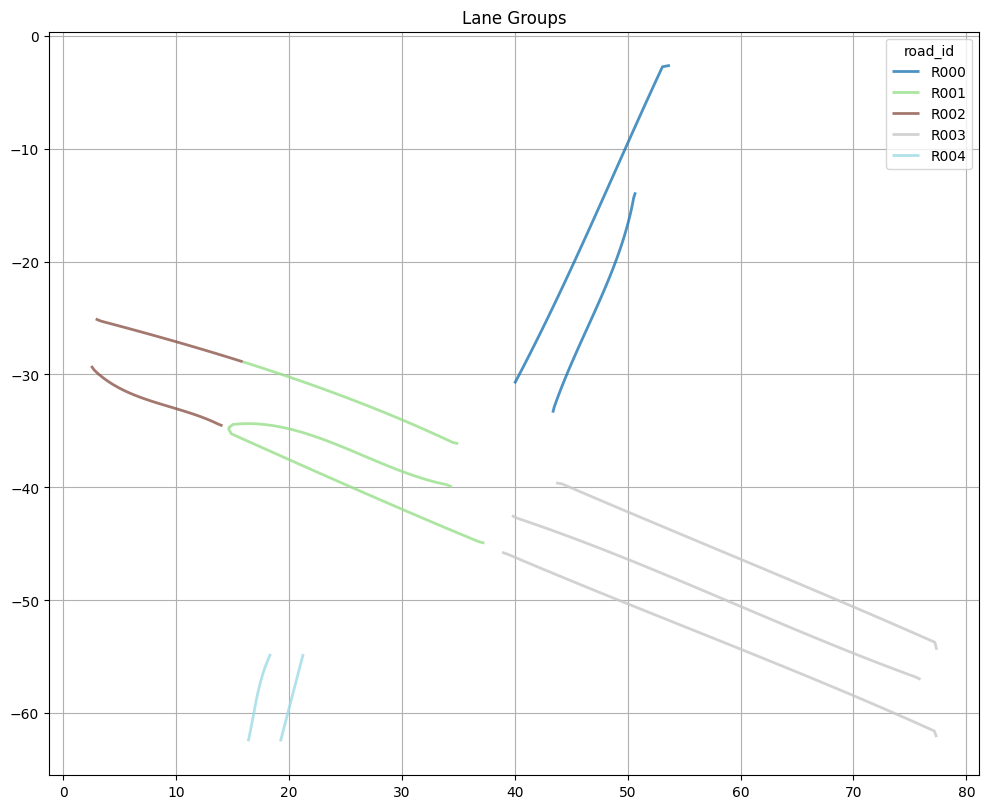

In [4]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString
from collections import defaultdict

def resample_line_spacing(line: LineString, spacing: float = 0.5) -> LineString:
    """
    Resample a LineString at ~uniform spacing along arc length.
    Keeps endpoints and inserts intermediate points every `spacing`.
    """
    L = line.length
    if L < spacing:
        return line
    n = int(L // spacing) + 2
    return LineString([line.interpolate(d) for d in np.linspace(0, L, n)])

def _reverse_ls(ls: LineString) -> LineString:
    """Return the reversed polyline (endpoints swapped)."""
    return LineString(list(ls.coords)[::-1])

def _avg_perp_distance(a: LineString, b: LineString, spacing: float = 1.0) -> float:
    """
    Average perpendicular distance from points sampled on `a`
    (every `spacing`) to the polyline `b`.
    """
    if a.length < 1e-6 or b.length < 1e-6:
        return np.inf
    n = max(int(a.length // spacing), 2)
    dists = [b.distance(a.interpolate(i * spacing)) for i in range(n)]
    return float(np.mean(dists)) if dists else np.inf

def _sym_avg_distance(a: LineString, b: LineString, spacing: float = 1.0) -> float:
    """
    Symmetric average distance = max( avg(a→b), avg(b→a) ).
    Using max is conservative and avoids asymmetric false positives.
    """
    return max(_avg_perp_distance(a, b, spacing),
               _avg_perp_distance(b, a, spacing))

def _best_aligned_pair(a: LineString, b: LineString, spacing: float = 1.0):
    """
    Try orientations and pick the pairing with the smallest symmetric distance.
    We consider (a, b), (a, rev(b)), and (rev(a), b).
    (rev(a), rev(b)) is equivalent to (a, b) and omitted.
    Returns: (best_cost, A_aligned, B_aligned)
    """
    candidates = [
        (a, b),
        (a, _reverse_ls(b)),
        (_reverse_ls(a), b),
    ]
    best = None
    best_pair = None
    for A, B in candidates:
        cost = _sym_avg_distance(A, B, spacing)
        if best is None or cost < best:
            best, best_pair = cost, (A, B)
    return best, best_pair[0], best_pair[1]

def _dir_vec(line: LineString, frac: float = 0.05) -> np.ndarray:
    """
    Robust direction estimate using two points away from the ends:
    v = P(1-frac) - P(frac). Helps on curvy polylines vs. using the raw endpoints.
    """
    L = max(line.length, 1e-9)
    p0 = np.array(line.interpolate(L * frac).coords[0])
    p1 = np.array(line.interpolate(L * (1 - frac)).coords[0])
    v = p1 - p0
    n = np.linalg.norm(v)
    return v / (n + 1e-12)

def _angle_deg_between(v1: np.ndarray, v2: np.ndarray) -> float:
    """Angle (degrees) between two unit-ish vectors."""
    c = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return float(np.degrees(np.arccos(c)))

def _endpoint_distances(l1: LineString, l2: LineString):
    """
    Return the four endpoint pair distances:
    start-start, end-end, start-end, end-start.
    """
    a0 = np.asarray(l1.coords[0]); a1 = np.asarray(l1.coords[-1])
    b0 = np.asarray(l2.coords[0]); b1 = np.asarray(l2.coords[-1])
    d_s_s = np.linalg.norm(a0 - b0)
    d_e_e = np.linalg.norm(a1 - b1)
    d_s_e = np.linalg.norm(a0 - b1)
    d_e_s = np.linalg.norm(a1 - b0)
    return d_s_s, d_e_e, d_s_e, d_e_s


# ----------------------------
# Core predicate
# ----------------------------

def lines_are_groupable(
    line1: LineString,
    line2: LineString,
    *,
    avg_tol: float = 3.0,
    endpoint_tol: float = 2.0,
    spacing: float = 1.0,
    angle_tol_deg: float = 25.0,     # max heading difference to be "same direction"
    serial_reject_tol: float = 2.0,  # reject same-direction head↔tail proximity (serial join)
    min_overlap_ratio: float = 0.0,  # optional along-track overlap requirement (0..1)
) -> bool:
    """
    Decide if two lane centerlines should be grouped as adjacent segments in the same corridor.

    Logic:
      1) Geometry distance is computed after automatic direction alignment
         (flip whichever side minimizes symmetric average distance).
      2) Direction-sensitive endpoint rule:
         - Same direction: require min(start↔start, end↔end) <= endpoint_tol
                           AND reject serial joins via min(start↔end, end↔start) > serial_reject_tol.
         - Opposite direction: require min(start↔end, end↔start) <= endpoint_tol.
      3) (Optional) Enforce a minimum along-track overlap between the aligned pair.
    """
    if line1.length < 1e-6 or line2.length < 1e-6:
        return False

    # 1) Use best-aligned orientation to evaluate geometric closeness.
    best_cost, A_dist, B_dist = _best_aligned_pair(line1, line2, spacing)
    if best_cost > avg_tol:
        return False

    # 2) Direction-sensitive endpoint rule (based on original headings).
    v1 = _dir_vec(line1); v2 = _dir_vec(line2)
    ang = _angle_deg_between(v1, v2)
    same_dir = (ang <= angle_tol_deg)   # ~180° is NOT treated as same direction here

    d_s_s, d_e_e, d_s_e, d_e_s = _endpoint_distances(line1, line2)

    if same_dir:
        # Adjacent same-direction lanes should have start~start or end~end close,
        # but should NOT be head-to-tail serial connections.
        if min(d_s_s, d_e_e) > endpoint_tol:
            return False
        if min(d_s_e, d_e_s) <= serial_reject_tol:
            return False  # serial (head↔tail) → reject
    else:
        # Opposite-direction adjacency: start~end or end~start should be close.
        if min(d_s_e, d_e_s) > endpoint_tol:
            return False

    # 3) Optional along-track overlap (computed on aligned pair).
    if min_overlap_ratio > 0.0:
        shorter, longer = (A_dist, B_dist) if A_dist.length <= B_dist.length else (B_dist, A_dist)
        d0 = longer.project(shorter.interpolate(0.0, normalized=True))
        d1 = longer.project(shorter.interpolate(1.0, normalized=True))
        ratio = abs(d1 - d0) / max(shorter.length, 1e-9)
        if ratio < min_overlap_ratio:
            return False

    return True


# ----------------------------
# Grouping over a GeoDataFrame
# ----------------------------

def group_lanes_by_geometry(
    gdf_lanes: gpd.GeoDataFrame,
    *,
    spacing: float = 0.5,       # resampling step for distance robustness
    avg_tol: float = 3.0,       # symmetric avg. distance threshold
    endpoint_tol: float = 2.0,  # endpoint proximity threshold
    angle_tol_deg: float = 25.0,
    serial_reject_tol: float = 2.0,
    min_overlap_ratio: float = 0.0,
    pair_expand: float = 6.0,   # prefilter radius for candidate pairs
) -> gpd.GeoDataFrame:
    """
    Group lane polylines into corridor IDs ("road_id") under direction-sensitive
    adjacency rules. Reverse-direction lanes along the same corridor are allowed,
    but serial connections are excluded.

    Expects gdf_lanes to have:
      - geometry: LineString
      - type == "lane" for lane rows
    """
    gdf = gdf_lanes[gdf_lanes["type"] == "lane"].copy().reset_index(drop=True)
    gdf["geometry_resampled"] = gdf["geometry"].apply(lambda g: resample_line_spacing(g, spacing=spacing))

    # Spatial index on original geometry to reduce pair checks.
    sindex = gdf.sindex

    # Union-Find (Disjoint Set) for grouping
    parent = {}
    def find(x):
        while parent.get(x, x) != x:
            x = parent[x]
        return x
    def union(x, y):
        parent[find(x)] = find(y)

    for i, row in gdf.iterrows():
        gi = row["geometry_resampled"]
        # Candidate neighbors: lines whose original geometry intersects the buffer.
        buf = row.geometry.buffer(pair_expand)
        cand_idx = list(sindex.query(buf, predicate="intersects"))
        for j in cand_idx:
            if j <= i:
                continue
            gj = gdf.at[j, "geometry_resampled"]
            if lines_are_groupable(
                gi, gj,
                avg_tol=avg_tol,
                endpoint_tol=endpoint_tol,
                spacing=max(0.5, spacing),
                angle_tol_deg=angle_tol_deg,
                serial_reject_tol=serial_reject_tol,
                min_overlap_ratio=min_overlap_ratio,
            ):
                union(i, j)

    # Assign contiguous corridor IDs
    groups = defaultdict(list)
    for i in range(len(gdf)):
        groups[find(i)].append(i)

    id_map = {}
    for k, (_, members) in enumerate(groups.items()):
        rid = f"R{k:03d}"
        for m in members:
            id_map[m] = rid

    gdf["road_id"] = gdf.index.map(id_map)
    return gdf.drop(columns=["geometry_resampled"])




import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

gdf_links = lanes_and_links_refined[lanes_and_links_refined["type"] == "link"]

from shapely.geometry import Point


def get_junction_points(gdf_lanes, tol=1.0):
    """
    Collect split and merge points from annotated lane start/end types.
    """
    points = []
    for _, row in gdf_lanes.iterrows():
        if row["start_type"] in {"merge"}:
            points.append(Point(row.geometry.coords[0]))
        if row["end_type"] in {"split"}:
            points.append(Point(row.geometry.coords[-1]))
    return points




# 3. Cut lanes at those points

import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

def plot_lane_cuts(gdf_lanes, junction_points, cut_length=5.0, tol=1.0, figsize=(10, 10)):
    """
    Plot lanes, junction points, and orthogonal cut lines.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot lanes
    for _, row in gdf_lanes.iterrows():
        x, y = row.geometry.xy
        ax.plot(x, y, color="gray", linewidth=1.5)

    # Plot junctions and cut lines
    for jp in junction_points:
        ax.plot(jp.x, jp.y, "ro", markersize=6, label="junction" if "junction" not in ax.get_legend_handles_labels()[1] else "")

        # Find nearest lane for visualization
        nearest_geom = min(gdf_lanes.geometry, key=lambda g: g.distance(jp))
        if nearest_geom.distance(jp) < tol:
            proj_dist = nearest_geom.project(jp)
            nearest_pt = nearest_geom.interpolate(proj_dist)

            # Tangent vector
            delta = 1e-6 * nearest_geom.length
            before = nearest_geom.interpolate(max(proj_dist - delta, 0))
            after = nearest_geom.interpolate(min(proj_dist + delta, nearest_geom.length))
            tangent = np.array(after.coords[0]) - np.array(before.coords[0])
            tangent /= (np.linalg.norm(tangent) + 1e-8)

            # Orthogonal vector
            normal = np.array([-tangent[1], tangent[0]])

            # Cutting line
            cut_line = LineString([
                nearest_pt.coords[0] - cut_length * normal,
                nearest_pt.coords[0] + cut_length * normal
            ])

            x, y = cut_line.xy
            ax.plot(x, y, "b--", linewidth=2, label="cut line" if "cut line" not in ax.get_legend_handles_labels()[1] else "")

    ax.set_aspect("equal")
    ax.legend()
    ax.set_title("Lane cuts at junctions (red=junction, blue=cut line)")
    plt.show()
gdf_lanes = lanes_and_links_refined[lanes_and_links_refined["type"] == "lane"].copy().reset_index(drop=True)
junction_points = get_junction_points(gdf_lanes)
print(f"Found {len(junction_points)} junction points.")
# plot_lane_cuts(gdf_lanes, junction_points, cut_length=10.0)
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, Point, MultiLineString
from shapely.ops import split as shp_split
from shapely.ops import substring as shp_substring



def _snap_point_to_line(line: LineString, pt: Point):
    d = line.project(pt)
    return line.interpolate(d), d


def _unique_sorted_distances(ds, length, min_gap=0.25, eps=1e-9):
    ds = [float(d) for d in ds if (d > eps and d < (length - eps))]
    if not ds:
        return []
    ds = sorted(ds)
    kept = [ds[0]]
    for d in ds[1:]:
        if d - kept[-1] >= max(min_gap, 0.0):
            kept.append(d)
    return kept


def _segments_via_substring(line: LineString, cut_ds, min_seg_len=0.25):
    if not cut_ds:
        return [line]
    length = line.length
    bounds = [0.0] + cut_ds + [length]
    segs = []
    for a, b in zip(bounds[:-1], bounds[1:]):
        if (b - a) >= min_seg_len:
            segs.append(shp_substring(line, a, b, normalized=False))
    return segs


def _segments_via_split(line: LineString, cut_pts, min_seg_len=0.25):
    if not cut_pts:
        return [line]
    cutters = []
    for pt in cut_pts:
        d = line.project(pt)
        delta = 1e-6 * line.length if line.length > 0 else 1e-6
        p0 = line.interpolate(max(d - delta, 0.0))
        p1 = line.interpolate(min(d + delta, line.length))
        t = np.array(p1.coords[0]) - np.array(p0.coords[0])
        nrm = np.linalg.norm(t)
        if nrm < 1e-12:
            continue
        t /= nrm
        n = np.array([-t[1], t[0]])
        L = max(1.0, 0.02 * line.length)
        a = (pt.x - L * n[0], pt.y - L * n[1])
        b = (pt.x + L * n[0], pt.y + L * n[1])
        cutters.append(LineString([a, b]))
    if not cutters:
        return [line]
    parts = shp_split(line, MultiLineString(cutters))
    return [seg for seg in parts.geoms if seg.length >= min_seg_len]


def split_lines_at_junctions(
    gdf_lines: gpd.GeoDataFrame,
    junction_points: list[Point],
    tol: float = 1.0,
    min_gap: float = 0.25,
    min_seg_len: float = 0.25,
    keep_cols: list[str] = None,
) -> gpd.GeoDataFrame:
    """
    Split each LineString in gdf_lines at nearby junction points.
    Uses GeoPandas sindex if available; otherwise uses Shapely STRtree
    (without relying on object identity).
    """
    if keep_cols is None:
        keep_cols = [c for c in gdf_lines.columns if c != "geometry"]

    if not junction_points:
        out = gdf_lines.copy()
        out["seg_idx"] = 0
        out["n_segs"] = 1
        return out

    # Build a GeoSeries for junction points and try GeoPandas sindex first
    gs_pts = gpd.GeoSeries(junction_points, crs=gdf_lines.crs)
    sindex = getattr(gs_pts, "sindex", None)

    # Fallback: Shapely STRtree (no id mapping)
    tree = None
    if sindex is None:
        try:
            from shapely.strtree import STRtree
            tree = STRtree(list(gs_pts))
        except Exception:
            tree = None  # final fallback: brute force filter by intersects

    out_rows = []
    for _, row in gdf_lines.iterrows():
        geom = row.geometry
        attrs = row[keep_cols].to_dict()

        def handle_line(line: LineString):
            if line.is_empty or line.length < 1e-9:
                return [line]

            buf = line.buffer(tol)

            # ---- candidate points near the buffered line ----
            if sindex is not None:
                idxs = list(sindex.query(buf, predicate="intersects"))
                cand_pts = [gs_pts.iloc[i] for i in idxs]
            elif tree is not None:
                cand_pts = list(tree.query(buf))
            else:
                # last-resort: brute force
                cand_pts = [p for p in gs_pts if p.intersects(buf)]

            # snap/filter
            cut_ds = []
            for p in cand_pts:
                if line.distance(p) <= tol:
                    _, d = _snap_point_to_line(line, p)
                    cut_ds.append(d)
            cut_ds = _unique_sorted_distances(cut_ds, line.length, min_gap=min_gap)

            segs = _segments_via_substring(line, cut_ds, min_seg_len=min_seg_len)
            return segs

        if isinstance(geom, MultiLineString):
            parts = []
            for part in geom.geoms:
                parts.extend(handle_line(part))
        elif isinstance(geom, LineString):
            parts = handle_line(geom)
        else:
            parts = [geom]

        n = len(parts)
        for i, seg in enumerate(parts):
            new_row = dict(attrs)
            new_row["geometry"] = seg
            new_row["seg_idx"] = i
            new_row["n_segs"] = n
            out_rows.append(new_row)

    return gpd.GeoDataFrame(out_rows, geometry="geometry", crs=gdf_lines.crs)

gdf_lanes_split = split_lines_at_junctions(
    gdf_lanes,
    junction_points,
    tol=10.0,        # tolerance in your CRS units
    min_gap=0.5,    # avoid over-splitting at near-duplicate cuts
    min_seg_len=0.5 # drop tiny fragments
)

print(len(gdf_lanes), "lanes →", len(gdf_lanes_split), "segments")

gdf_lanes_grouped = group_lanes_by_geometry(
    gdf_lanes_split,
    spacing=0.5,          # Resample step along each line (in CRS units, e.g., meters).
    avg_tol=10,          # Max symmetric avg. perpendicular distance to treat lanes as the same corridor.
    endpoint_tol=10,     # Endpoint proximity threshold: at least one valid endpoint pair must be within this.
    angle_tol_deg=25.0,   # Max heading difference to be considered "same direction" (excludes ~180° flips).
    serial_reject_tol=1.5,# If start↔end or end↔start is <= this (when same direction), reject as serial (head-to-tail).
    min_overlap_ratio=0.2,# Min fraction of the shorter line that must overlap the longer one (0..1).
    pair_expand=6.0       # Search radius to gather candidate neighbors before detailed checks.
)

visualize_road_groups(gdf_lanes_grouped, label_col='road_id')


Road ID: R000, Lane idx: 0, Angle: 0.00°, Direction: 1
Road ID: R000, Lane idx: 1, Angle: 163.96°, Direction: -1
Road ID: R001, Lane idx: 2, Angle: 0.00°, Direction: 1
Road ID: R001, Lane idx: 5, Angle: 150.55°, Direction: -1
Road ID: R001, Lane idx: 6, Angle: -171.95°, Direction: -1
Road ID: R002, Lane idx: 3, Angle: 0.00°, Direction: 1
Road ID: R002, Lane idx: 4, Angle: -158.60°, Direction: -1
Road ID: R003, Lane idx: 7, Angle: 0.00°, Direction: 1
Road ID: R003, Lane idx: 8, Angle: 165.98°, Direction: -1
Road ID: R003, Lane idx: 9, Angle: 167.91°, Direction: -1
Road ID: R004, Lane idx: 10, Angle: 0.00°, Direction: 1
Road ID: R004, Lane idx: 11, Angle: -175.97°, Direction: -1
Processing bidirectional road: R000
Processing bidirectional road: R001
Processing bidirectional road: R002
Processing bidirectional road: R003
Processing bidirectional road: R004


<Axes: title={'center': 'Road Groups with Reference Lines'}>

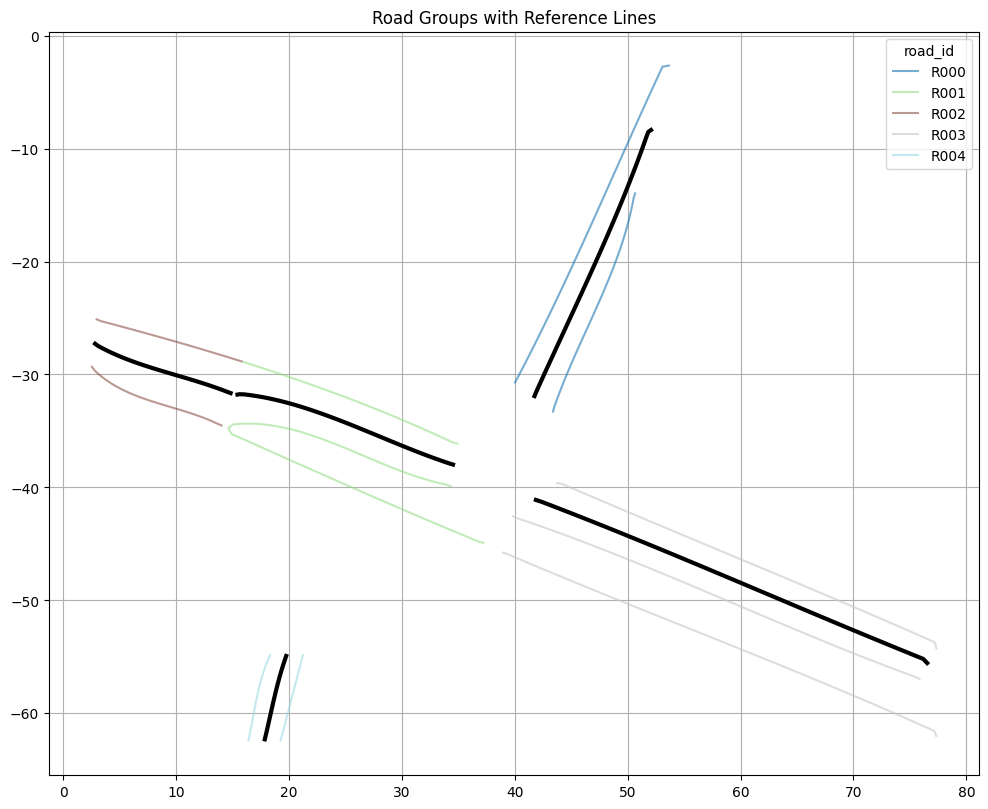

In [5]:
def resample_line_points(line, num_points=50):
    """Uniformly sample a fixed number of points along the line."""
    return np.array([[pt.x, pt.y] for pt in [line.interpolate(d) for d in np.linspace(0, line.length, num_points)]])

def infer_lane_directions_from_geometry(gdf_lanes, num_points=10, head_segment_length=3):
    """
    Infer lane direction using the signed angle between each lane and a reference lane.
    Assigns lane_dir = 1 if aligned with reference, -1 otherwise.
    """
    gdf_lanes = gdf_lanes.copy()
    gdf_lanes["lane_dir"] = 0  # placeholder

    def get_head_vector(geom, length=3):
        coords = np.array(geom.coords)
        if len(coords) < 2:
            return np.array([0, 0])
        dists = np.cumsum([0] + [np.linalg.norm(coords[i+1] - coords[i]) for i in range(len(coords)-1)])
        idx = np.searchsorted(dists, length)
        if idx >= len(coords): idx = len(coords) - 1
        vec = coords[idx] - coords[0]
        return vec / (np.linalg.norm(vec) + 1e-8)

    def angle_between(u, v):
        cross = u[0]*v[1] - u[1]*v[0]
        dot = np.dot(u, v)
        return np.rad2deg(np.arctan2(cross, dot))

    for road_id, group in gdf_lanes.groupby("road_id"):
        ref_geom = group.iloc[0].geometry
        ref_vec = get_head_vector(ref_geom, head_segment_length)

        for idx, row in group.iterrows():
            lane_vec = get_head_vector(row.geometry, head_segment_length)
            angle = angle_between(lane_vec, ref_vec)
            lane_dir = 1 if abs(angle) < 90 else -1

            gdf_lanes.at[idx, "lane_dir"] = lane_dir
            print(f"Road ID: {road_id}, Lane idx: {idx}, Angle: {angle:.2f}°, Direction: {lane_dir}")

    return gdf_lanes

from shapely.geometry import LineString
import numpy as np


def resample_line_points(geom, num_points=50):
    return np.array([
        geom.interpolate(i / (num_points - 1), normalized=True).coords[0]
        for i in range(num_points)
    ])

def compute_signed_offset(ref_pts, lane_pts, method="mean"):
    """
    Compute average signed lateral offset from lane_pts to ref_pts.
    Ref and lane must be resampled to the same length.
    method: 'mean' | 'median' | 'trimmed'
    """
    offsets = []
    for i in range(len(ref_pts) - 1):
        dx, dy = ref_pts[i + 1] - ref_pts[i]
        norm = np.hypot(dx, dy)
        if norm < 1e-6:
            continue
        nx, ny = -dy / norm, dx / norm  # left-hand normal

        vx, vy = lane_pts[i] - ref_pts[i]
        offset = vx * nx + vy * ny
        offsets.append(offset)

    offsets = np.array(offsets)

    if method == "median":
        return np.median(offsets)
    elif method == "trimmed":
        from scipy.stats import trim_mean
        return trim_mean(offsets, proportiontocut=0.1)
    else:  # default: mean
        return np.mean(offsets)

def shift_reference_line_to_outer_edge(center_line, shift_amount):
    coords = np.array(center_line.coords)
    if len(coords) < 2:
        return center_line
    t = coords[-1] - coords[0]
    t /= (np.linalg.norm(t) + 1e-8)
    normal = np.array([-t[1], t[0]])  # left-hand normal
    shifted_coords = coords + shift_amount * normal
    return LineString(shifted_coords)

def compute_reference_lines_direction_aware(gdf_lanes, num_points=50, average_lane_width=False):
    """
    Compute reference lines and lane widths for each road_id in gdf_lanes.
    Adds: lane_width, lane_offset, avg_offset
    Returns: dict {road_id: LineString}, updated gdf_lanes
    """
    ref_lines = {}
    gdf_lanes = gdf_lanes.copy()
    gdf_lanes["lane_width"] = 0.0
    gdf_lanes["lane_offset"] = 0.0
    gdf_lanes["avg_offset"] = 0.0

    for road_id, group in gdf_lanes.groupby("road_id"):
        lanes_pos = group[group["lane_dir"] == 1]
        lanes_neg = group[group["lane_dir"] == -1]
        group = group.reset_index()
        is_bidirectional = not lanes_pos.empty and not lanes_neg.empty

        if is_bidirectional:
            print(f"Processing bidirectional road: {road_id}")

            def resample_and_align(geom, ref_coords):
                coords = resample_line_points(geom, num_points)
                d_forward = np.linalg.norm(ref_coords[0] - coords[0])
                d_reverse = np.linalg.norm(ref_coords[0] - coords[-1])
                return coords if d_forward < d_reverse else coords[::-1]

            ref_coords = resample_line_points(lanes_pos.iloc[0].geometry, num_points)
            best_pair = None
            min_dist = float("inf")

            for pos_geom in lanes_pos.geometry:
                pos_coords = resample_and_align(pos_geom, ref_coords)
                for neg_geom in lanes_neg.geometry:
                    neg_coords = resample_and_align(neg_geom, ref_coords)
                    dist = np.mean(np.linalg.norm(pos_coords - neg_coords, axis=1))
                    if dist < min_dist:
                        best_pair = (pos_coords, neg_coords)
                        min_dist = dist

            center_coords = 0.5 * (best_pair[0] + best_pair[1])
            ref_line = LineString(center_coords)

            # Assign avg_offset
            for _, row in group.iterrows():
                lane_pts = resample_line_points(row.geometry, num_points)
                offset = compute_signed_offset(center_coords, lane_pts, method="trimmed")
                gdf_lanes.at[row["index"], "avg_offset"] = offset

            # Compute left/right separately
            group_idx = group["index"].values
            avg_offsets = gdf_lanes.loc[group_idx, "avg_offset"]
            left_mask = avg_offsets < 0
            right_mask = avg_offsets > 0

            left_indices = group_idx[left_mask.values]
            right_indices = group_idx[right_mask.values]
            
            left_lanes = gdf_lanes.loc[left_indices].copy().sort_values(by="avg_offset", ascending=False)
            right_lanes = gdf_lanes.loc[right_indices].copy().sort_values(by="avg_offset")

            offset_acc = 0.0
            for idx, row in left_lanes.iterrows():
                center = abs(gdf_lanes.at[idx, "avg_offset"])
                width = 2 * (center - offset_acc)
                gdf_lanes.at[idx, "lane_width"] = width
                gdf_lanes.at[idx, "lane_offset"] = offset_acc
                offset_acc += width

            offset_acc = 0.0
            for idx, row in right_lanes.iterrows():
                center = abs(gdf_lanes.at[idx, "avg_offset"])
                width = 2 * (center - offset_acc)
                gdf_lanes.at[idx, "lane_width"] = width
                gdf_lanes.at[idx, "lane_offset"] = offset_acc
                offset_acc += width
            if average_lane_width:
                gdf_lanes["lane_width"] = gdf_lanes.groupby("road_id")["lane_width"].transform("mean")
        else:
            print(f"Processing one-directional road: {road_id}")
            sampled_lines = []
            ref_coords = resample_line_points(group.iloc[0].geometry, num_points)

            for geom in group.geometry:
                coords = resample_line_points(geom, num_points)
                d_forward = np.linalg.norm(ref_coords[0] - coords[0])
                d_reverse = np.linalg.norm(ref_coords[0] - coords[-1])
                if d_reverse < d_forward:
                    coords = coords[::-1]
                sampled_lines.append(coords)

            center_coords = np.mean(np.stack(sampled_lines), axis=0)
            center_line = LineString(center_coords)

            # Compute avg_offset
            for _, row in group.iterrows():
                lane_pts = resample_line_points(row.geometry, num_points)
                offset = compute_signed_offset(center_coords, lane_pts, method="trimmed")
                gdf_lanes.at[row["index"], "avg_offset"] = offset
                
            group_idx = group["index"].values
            avg_offsets = gdf_lanes.loc[group_idx, "avg_offset"]
            left_mask = avg_offsets < 0
            right_mask = avg_offsets > 0

            left_indices = group_idx[left_mask.values]
            right_indices = group_idx[right_mask.values]
            
            left_lanes = gdf_lanes.loc[left_indices].copy().sort_values(by="avg_offset", ascending=False)
            right_lanes = gdf_lanes.loc[right_indices].copy().sort_values(by="avg_offset")

            offset_acc = 0.0
            for idx, row in left_lanes.iterrows():
                center = abs(gdf_lanes.at[idx, "avg_offset"])
                width = 2 * (center - offset_acc)
                gdf_lanes.at[idx, "lane_width"] = width
                gdf_lanes.at[idx, "lane_offset"] = offset_acc
                offset_acc += width

            offset_acc = 0.0
            for idx, row in right_lanes.iterrows():
                center = abs(gdf_lanes.at[idx, "avg_offset"])
                width = 2 * (center - offset_acc)
                gdf_lanes.at[idx, "lane_width"] = width
                gdf_lanes.at[idx, "lane_offset"] = offset_acc
                offset_acc += width
            if average_lane_width:
                gdf_lanes["lane_width"] = gdf_lanes.groupby("road_id")["lane_width"].transform("mean")
            sorted_lanes = group.reindex(np.argsort(np.abs(group["avg_offset"])))
            offset_acc = 0.0
            # Compute left/right separately


            # Shift to outer edge
            outermost = sorted_lanes.iloc[-1]
            print(gdf_lanes.at[outermost["index"], "lane_width"])
            shift_amount = abs(gdf_lanes.at[outermost["index"], "avg_offset"]) + 0.5 * gdf_lanes.at[outermost["index"], "lane_width"]
            ref_line = shift_reference_line_to_outer_edge(center_line, shift_amount)

        ref_lines[road_id] = ref_line

    return ref_lines, gdf_lanes


import matplotlib.pyplot as plt
from shapely.geometry import LineString

def plot_lane_directions(gdf_lanes, title="Lane Directions", figsize=(10, 10), arrow_length=5):
    fig, ax = plt.subplots(figsize=figsize)
    
    for _, row in gdf_lanes.iterrows():
        geom = row.geometry
        if not isinstance(geom, LineString) or len(geom.coords) < 2:
            continue

        coords = list(geom.coords)
        x, y = zip(*coords)
        ax.plot(x, y, color='gray', linewidth=1, alpha=0.6)

        # Direction arrow
        start = np.array(coords[0])
        end = np.array(coords[-1])
        dir_vec = end - start
        dir_vec = dir_vec / (np.linalg.norm(dir_vec) + 1e-8) * arrow_length

        # Choose color by direction
        dir_val = row.get("lane_dir", 0)
        color = "blue" if dir_val == 1 else "red" if dir_val == -1 else "black"

        ax.arrow(start[0], start[1], dir_vec[0], dir_vec[1],
                 head_width=1.0, head_length=1.5, fc=color, ec=color)

    ax.set_title(title)
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()

from shapely.ops import split
from shapely.geometry import Point

gdf_lanes = infer_lane_directions_from_geometry(gdf_lanes_grouped)
# 1. Compute direction-aware centerlines
ref_lines, gdf_lanes= compute_reference_lines_direction_aware(gdf_lanes, average_lane_width=True)
gdf_lanes['reference_geom'] = gdf_lanes.apply(lambda row: ref_lines.get(row['road_id'], None), axis=1)


visualize_road_groups_with_reference_lines(gdf_lanes, ref_lines)

In [6]:
def assign_lane_ids_per_group(gdf_lanes, ref_lines, num_points=50):
    """
    Assign OpenDRIVE-compliant lane IDs (+1, -1, etc.) based on signed lateral offset.
    No flipping of geometry is done here.
    """
    gdf_lanes = gdf_lanes.copy()

    for road_id, group in gdf_lanes.groupby("road_id"):
        ref_line = ref_lines[road_id]
        ref_pts = np.array([[pt.x, pt.y] for pt in [ref_line.interpolate(d) for d in np.linspace(0, ref_line.length, num_points)]])

        lane_offsets = []

        for idx, row in group.iterrows():
            line = row.geometry
            lane_pts = np.array([[pt.x, pt.y] for pt in [line.interpolate(d) for d in np.linspace(0, line.length, num_points)]])

            # No flipping — just compute signed lateral offset
            signed_offset = row['avg_offset']
            lane_offsets.append((idx, signed_offset))

        # Sort by offset
        # sorted_lanes = sorted(lane_offsets, key=lambda x: x[1])
        # sort the positive and negative offsets separately
        left_lanes = [x for x in lane_offsets if x[1] > 0]
        right_lanes = [x for x in lane_offsets if x[1] < 0]
        sorted_left_lanes = sorted(left_lanes, key=lambda x: x[1])
        sorted_right_lanes = sorted(right_lanes, key=lambda x: x[1], reverse=True)
        

        lane_id_map = {}
        current_left = -1
        current_right = 1

        for idx, offset in sorted_left_lanes:
            lane_id_map[idx] = (current_left, "left")
            current_left -= 1

        for idx, offset in sorted_right_lanes:
            lane_id_map[idx] = (current_right, "right")
            current_right += 1

        for idx, (lid, side) in lane_id_map.items():
            gdf_lanes.at[idx, "lane_id"] = lid
            gdf_lanes.at[idx, "lane_side"] = side
 
    return gdf_lanes

gdf_lanes = assign_lane_ids_per_group(gdf_lanes, ref_lines)


In [8]:
gdf_lanes.to_parquet("lanes.parquet", index=False)

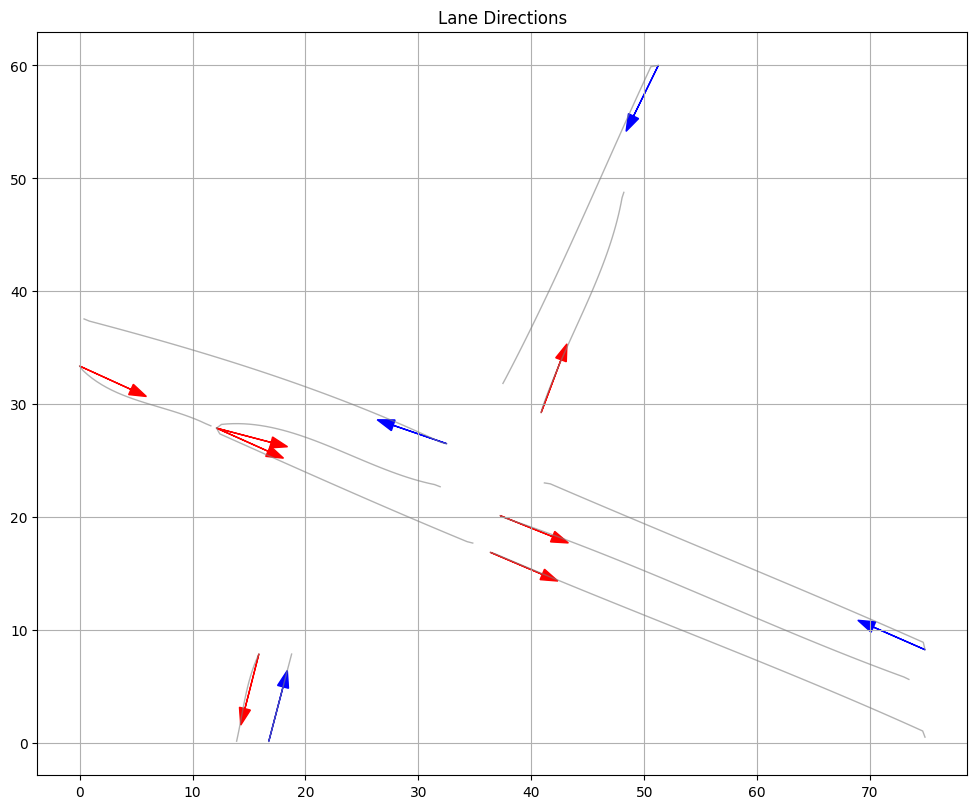

In [60]:
plot_lane_directions(gdf_lanes, figsize=(12, 12), arrow_length=5)

In [18]:
def enrich_links_with_road_ids(gdf_links, gdf_lanes):
    """
    For each link, map from_fid and to_fid to the road_id of the corresponding lanes.
    """
    fid_to_road = gdf_lanes.set_index("fid")["road_id"].to_dict()
    fid_to_lane_id = gdf_lanes.set_index("fid")["lane_id"].to_dict()

    gdf_links = gdf_links.copy()
    gdf_links["incoming_road_id"] = gdf_links["from_fid"].map(fid_to_road)
    gdf_links["outgoing_road_id"] = gdf_links["to_fid"].map(fid_to_road)
    gdf_links["from_lane_id"] = gdf_links["from_fid"].map(fid_to_lane_id)
    gdf_links["to_lane_id"] = gdf_links["to_fid"].map(fid_to_lane_id)

    return gdf_links


def determine_lane_side(ref_line: LineString, lane_line: LineString) -> str:
    """Determine if lane is on 'left' or 'right' of the reference line."""
    # Sample 3 points to avoid instability
    num_points = 3
    ref_pts = np.linspace(0, ref_line.length, num=num_points)
    lane_pts = np.linspace(0, lane_line.length, num=num_points)

    offset_sum = 0
    for s in range(num_points - 1):
        r = np.array(ref_line.interpolate(ref_pts[s]).coords[0])
        r_next = np.array(ref_line.interpolate(ref_pts[s+1]).coords[0])
        l = np.array(lane_line.interpolate(lane_pts[s]).coords[0])

        vec = r_next - r
        norm = np.linalg.norm(vec)
        if norm == 0:
            continue
        tangent = vec / norm
        normal = np.array([-tangent[1], tangent[0]])  # left-hand normal

        diff = l - r
        offset = np.dot(diff, normal)
        offset_sum += offset

    return "left" if offset_sum > 0 else "right"


def compute_angle(v1, v2):
    """Compute angle in degrees between two vectors, safely."""
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def shift_linestring(line: LineString, offset: float, angle_thresh=10, smooth_window=10, polyorder=2) -> LineString:
    coords = np.asarray(line.coords)
    if len(coords) < 2:
        return line

    start_pt = coords[0]
    end_pt = coords[-1]

    valid_idx = []
    for i in range(1, len(coords) - 1):
        v1 = coords[i] - coords[i - 1]
        v2 = coords[i + 1] - coords[i]
        angle = compute_angle(v1, v2)
        if angle <= angle_thresh:
            valid_idx.append(i)

    if not valid_idx:
        return LineString([start_pt, end_pt])  # only endpoints remain

    # Always keep endpoints
    keep_indices = [0] + valid_idx + [len(coords) - 1]

    shifted_coords = []
    for i in keep_indices:
        if i == 0:
            vec = coords[1] - coords[0]
        elif i == len(coords) - 1:
            vec = coords[-1] - coords[-2]
        else:
            vec = coords[i + 1] - coords[i - 1]

        norm = np.linalg.norm(vec)
        if norm == 0:
            shifted_coords.append(coords[i])
            continue
        tangent = vec / norm
        normal = np.array([-tangent[1], tangent[0]])
        shifted_coords.append(coords[i] + offset * normal)

    shifted_coords = np.array(shifted_coords)

    # Smoothing
    if len(shifted_coords) >= smooth_window:
        try:
            x_smooth = savgol_filter(shifted_coords[:, 0], smooth_window, polyorder)
            y_smooth = savgol_filter(shifted_coords[:, 1], smooth_window, polyorder)
            shifted_coords = np.column_stack([x_smooth, y_smooth])
        except Exception as e:
            print(f"[WARN] Savitzky-Golay smoothing failed: {e}")

    return LineString(shifted_coords)



def enrich_links_with_lane_geometry(gdf_links, gdf_lanes):
    """
    Update gdf_links in-place: estimate lane width/offset/side/lane_id, assign road_id, compute reference_geom.
    Lane side is computed using OpenDRIVE geometric convention.
    """
    # Lookup lane widths
    fid2width = gdf_lanes.set_index("fid")["lane_width"].to_dict()

    lane_widths, lane_offsets, lane_sides = [], [], []
    road_ids, ref_lines, lane_ids = [], [], []

    for idx, row in gdf_links.iterrows():
        from_fid = row["from_fid"]
        to_fid = row["to_fid"]

        w1 = fid2width.get(from_fid, 3.5)
        w2 = fid2width.get(to_fid, 3.5)
        avg_width = (w1 + w2) / 2

        center_line = row["geometry"]
        offset = avg_width / 2  # magnitude only for now

        # Estimate reference line (shift toward right, guess)
        ref_guess = shift_linestring(center_line, -offset)

        # Determine left/right using standard
        side = determine_lane_side(ref_guess, center_line)

        # Correct ref_line shift based on actual side
        signed_offset = offset if side == "left" else -offset
        ref_line = shift_linestring(center_line, signed_offset)

        lane_id = -1 if side == "left" else 1

        lane_widths.append(avg_width)
        lane_offsets.append(signed_offset)
        lane_sides.append(side)
        lane_ids.append(lane_id)
        road_ids.append(f"L{idx:03d}")
        ref_lines.append(ref_line)

    gdf_links["lane_width"] = lane_widths
    gdf_links["lane_offset"] = lane_offsets
    gdf_links["lane_side"] = lane_sides
    gdf_links["lane_id"] = lane_ids
    gdf_links["road_id"] = road_ids
    gdf_links["reference_geom"] = ref_lines

    return gdf_links



def enrich_links_with_lane_geometry(gdf_links, gdf_lanes):
    """
    Update gdf_links in-place: estimate lane width/offset/side/lane_id, assign road_id, compute reference_geom.
    Lane side is computed using OpenDRIVE geometric convention.
    """
    # Lookup lane widths
    fid2width = gdf_lanes.set_index("fid")["lane_width"].to_dict()

    lane_widths, lane_offsets, lane_sides = [], [], []
    road_ids, ref_lines, lane_ids = [], [], []

    for idx, row in gdf_links.iterrows():
        from_fid = row["from_fid"]
        to_fid = row["to_fid"]

        w1 = fid2width.get(from_fid, 3.5)
        w2 = fid2width.get(to_fid, 3.5)
        avg_width = (w1 + w2) / 2

        center_line = row["geometry"]
        offset = avg_width / 2  # magnitude only for now

        # Estimate reference line (shift toward right, guess)
        ref_guess = shift_linestring(center_line, -offset)

        # Determine left/right using standard
        side = determine_lane_side(ref_guess, center_line)

        # Correct ref_line shift based on actual side
        signed_offset = offset if side == "left" else -offset
        ref_line = shift_linestring(center_line, signed_offset)

        lane_id = -1 if side == "left" else 1

        lane_widths.append(avg_width)
        lane_offsets.append(signed_offset)
        lane_sides.append(side)
        lane_ids.append(lane_id)
        road_ids.append(f"L{idx:03d}")
        ref_lines.append(ref_line)

    gdf_links["lane_width"] = lane_widths
    gdf_links["lane_offset"] = lane_offsets
    gdf_links["lane_side"] = lane_sides
    gdf_links["lane_id"] = lane_ids
    gdf_links["road_id"] = road_ids
    gdf_links["reference_geom"] = ref_lines

    return gdf_links

gdf_links = enrich_links_with_road_ids(gdf_links, gdf_lanes)
gdf_links = enrich_links_with_lane_geometry(gdf_links, gdf_lanes)
gdf_links['junction_id'] = 'J000'
gdf_lanes['junction_id'] = np.nan

In [21]:
gdf_lanes

,fid,type,start_type,end_type,from_fid,to_fid,geometry,road_id,lane_dir,lane_width,lane_offset,avg_offset,reference_geom,lane_id,lane_side
0,0,lane,in,out,None,None,"LINESTRING (51.25 60, 50.5893 59.88025, 50.384...",R000,1,3.000204,0.000000,-1.636372,"LINESTRING (49.72347 54.37796, 49.3391 54.1180...",-1.0,left
1,1,lane,in,out,None,None,"LINESTRING (40.875 29.25, 40.9995 29.73307, 41...",R000,-1,3.000204,0.000000,1.363832,"LINESTRING (49.72347 54.37796, 49.3391 54.1180...",1.0,right
2,2,lane,in,out,None,None,"LINESTRING (32.5 26.5, 32.01003 26.6116, 31.54...",R001,1,3.640440,0.000000,-2.282112,"LINESTRING (32.21358 24.59341, 31.68326 24.766...",-1.0,left
3,3,lane,in,split,None,None,"LINESTRING (0 33.375, 0.30166 32.97492, 0.6922...",R001,-1,3.640440,5.965507,3.836088,"LINESTRING (32.21358 24.59341, 31.68326 24.766...",2.0,right
4,4,lane,split,out,None,None,"LINESTRING (12.125 27.875, 12.56146 28.20436, ...",R001,-1,3.640440,0.000000,2.982754,"LINESTRING (32.21358 24.59341, 31.68326 24.766...",1.0,right
5,5,lane,split,out,None,None,"LINESTRING (12.125 27.875, 12.41322 27.36747, ...",R001,-1,3.640440,1.706668,5.852102,"LINESTRING (32.21358 24.59341, 31.68326 24.766...",3.0,right
6,6,lane,in,out,None,None,"LINESTRING (74.875 8.25, 74.71546 8.90659, 74....",R002,1,3.642084,0.000000,-1.923463,"LINESTRING (74.15833 6.93614, 73.67705 7.43987...",-1.0,left
7,7,lane,in,out,None,None,"LINESTRING (37.25 20.125, 37.70061 19.90654, 3...",R002,-1,3.642084,0.000000,2.029795,"LINESTRING (74.15833 6.93614, 73.67705 7.43987...",1.0,right
8,8,lane,in,out,None,None,"LINESTRING (36.375 16.875, 36.85988 16.71824, ...",R002,-1,3.642084,4.059591,5.569459,"LINESTRING (74.15833 6.93614, 73.67705 7.43987...",2.0,right
9,9,lane,in,out,None,None,"LINESTRING (16.75 0.125, 16.87651 0.60873, 17....",R003,1,2.818378,0.000000,-1.466009,"LINESTRING (15.32726 0.13631, 15.36491 0.29509...",-1.0,left


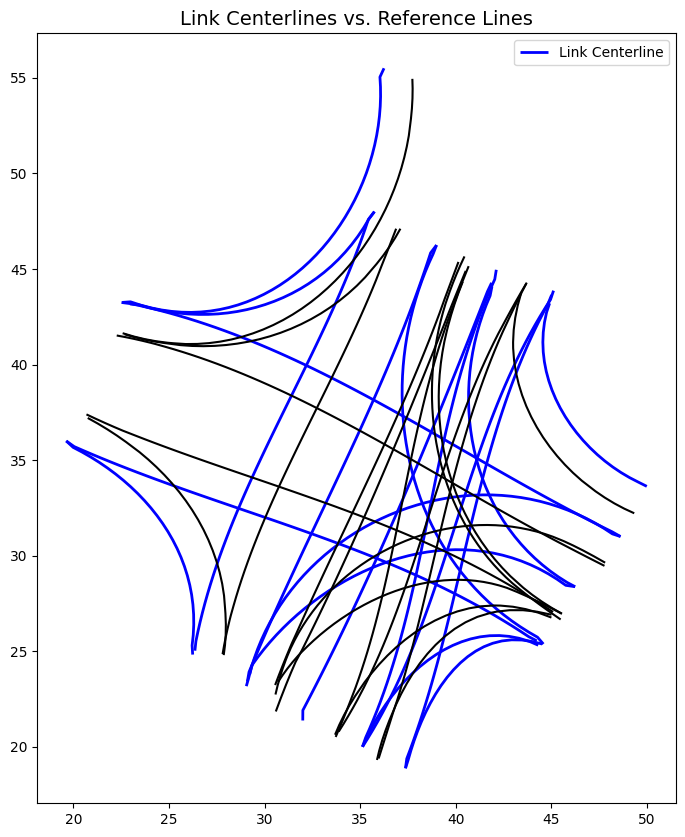

In [20]:

visualize_links_with_ref_lines(gdf_links)

In [ ]:
def calculate_heading(p0, p1):
    dx, dy = p1[0] - p0[0], p1[1] - p0[1]
    return np.arctan2(dy, dx)

from scipy.interpolate import CubicSpline
import numpy as np
from shapely.geometry import LineString

def generate_line_geometry(planview_elem, ref_line: LineString, s_start=0.0):
    """
    Add <geometry> segments with <line/> from a LineString to a given <planView> element.
    
    Args:
        planview_elem: XML element to append <geometry> elements to.
        ref_line: LineString geometry to convert.
        s_start: Starting 's' value for geometry length.
    Returns:
        Total length added to the planView.
    """
    coords = list(ref_line.coords)
    s = s_start

    for i in range(len(coords) - 1):
        x, y = coords[i]
        x2, y2 = coords[i + 1]
        seg_length = np.hypot(x2 - x, y2 - y)
        hdg = calculate_heading(coords[i], coords[i + 1])

        geometry = etree.SubElement(planview_elem, "geometry",
                                    s=f"{s:.8f}",
                                    x=f"{x:.8f}",
                                    y=f"{y:.8f}",
                                    hdg=f"{hdg:.8f}",
                                    length=f"{seg_length:.8f}")
        etree.SubElement(geometry, "line")
        s += seg_length

    return s - s_start  # total length added

def densify_linestring(line: LineString, resolution: float) -> LineString:
    """
    Resample LineString to have points at roughly uniform spacing.
    """
    num = max(int(line.length // resolution), 2)
    points = [line.interpolate(float(i) / num, normalized=True) for i in range(num + 1)]
    return LineString(points)

def generate_road_element(road_id, ref_line: LineString, gdf_lanes, gdf_links, junction_id="-1"):
    """
    Generate a complete <road> OpenDRIVE element, including planView, lanes, and topological <link>.

    Parameters:
    - road_id: ID of the road to generate.
    - ref_line: Centerline geometry as shapely LineString.
    - gdf_lanes: GeoDataFrame of lane segments (non-link roads).
    - gdf_links: GeoDataFrame of connecting roads with predecessor/successor fields.
    - junction_id: ID of the junction this road belongs to (default: -1 for standalone roads).
    """
    
    
    road_elem = etree.Element("road", id=str(road_id), name=str(road_id), length=f"{ref_line.length:.3f}", junction=str(junction_id))

    # Add <link> block for topological connectivity
    link_elem = etree.SubElement(road_elem, "link")
    
    fid_to_road_id_lanes = gdf_lanes.set_index("fid")["road_id"].to_dict()
    fid_to_road_id_links = gdf_links.set_index("fid")["road_id"].to_dict()
    fid_to_junction_id_lanes = gdf_lanes.set_index("fid")["junction_id"].to_dict()
    fid_to_junction_id_links = gdf_links.set_index("fid")["junction_id"].to_dict()

    fid_to_road_id = {**fid_to_road_id_lanes, **fid_to_road_id_links}
    fid_to_junction_id = {**fid_to_junction_id_lanes, **fid_to_junction_id_links}

    gdf_combined = pd.concat([gdf_lanes, gdf_links], ignore_index=True)
    is_link = False
    if road_id in gdf_links["road_id"].values:
        is_link = True
        road_data_row = gdf_links[gdf_links["road_id"] == road_id].iloc[0]
    elif road_id in gdf_lanes["road_id"].values:
        is_link = False
        road_data_row = gdf_lanes[gdf_lanes["road_id"] == road_id].iloc[0]
    else:
        # if the road id is invalid, raise exception
        raise ValueError(f"Invalid road_id: {road_id}. It does not exist in gdf_lanes or gdf_links.")

    
    cur_fid = road_data_row.get("fid")
    pred_fid = road_data_row.get("from_fid")
    succ_fid = road_data_row.get("to_fid")
    pred_lane_side = gdf_combined.loc[gdf_combined["fid"] == pred_fid, "lane_side"].values[0] if pd.notna(pred_fid) else None
    succ_lane_side = gdf_combined.loc[gdf_combined["fid"] == succ_fid, "lane_side"].values[0] if pd.notna(succ_fid) else None
    cur_lane_side = gdf_combined.loc[gdf_combined["fid"] == cur_fid, "lane_side"].values[0] if pd.notna(cur_fid) else None
    pred_road_id = fid_to_road_id.get(pred_fid)
    pred_junction_id = fid_to_junction_id.get(pred_fid)

    if pd.notna(pred_junction_id):
        etree.SubElement(link_elem, "predecessor", elementType="junction", elementId=str(pred_junction_id))
    elif pd.notna(pred_road_id):
        if pred_lane_side == cur_lane_side:
            etree.SubElement(link_elem, "predecessor", elementType="road", elementId=str(pred_road_id), contactPoint="end")
        else:
            etree.SubElement(link_elem, "predecessor", elementType="road", elementId=str(pred_road_id), contactPoint="start")

    
    succ_road_id = fid_to_road_id.get(succ_fid)
    succ_junction_id = fid_to_junction_id.get(succ_fid)

    if pd.notna(succ_junction_id):
        etree.SubElement(link_elem, "successor", elementType="junction", elementId=str(succ_junction_id))
    elif pd.notna(succ_road_id):
        if succ_lane_side == cur_lane_side:
            etree.SubElement(link_elem, "successor", elementType="road", elementId=str(succ_road_id), contactPoint="start")
        elif succ_lane_side == 'right':
            etree.SubElement(link_elem, "successor", elementType="road", elementId=str(succ_road_id), contactPoint="end")

    # --- planView ---
    planview = etree.SubElement(road_elem, "planView")
    ref_line = densify_linestring(ref_line, resolution=1.0)
    s_current = 0.0
    generate_line_geometry(planview, ref_line, s_start=s_current)

    # --- lanes ---
    lanes_elem = etree.SubElement(road_elem, "lanes")
    lane_section = etree.SubElement(lanes_elem, "laneSection", s="0.0")

    left_elem = etree.SubElement(lane_section, "left")
    right_elem = etree.SubElement(lane_section, "right")
    center_elem = etree.SubElement(lane_section, "center")
    etree.SubElement(center_elem, "lane", id="0", type="none", level="true")

    if is_link:
        lanes_to_add = gdf_links[gdf_links["road_id"] == road_id]
    else:
        lanes_to_add = gdf_lanes[gdf_lanes["road_id"] == road_id]

    for _, row in lanes_to_add.iterrows():
        lane_el = etree.Element("lane", id=str(int(row["lane_id"])), type="driving", level="true")
        etree.SubElement(
            lane_el, "width", sOffset="0.000",
            a=f"{row['lane_width']:.3f}", b="0.0", c="0.0", d="0.0"
        )
        if row["lane_side"] == "left":
            left_elem.append(lane_el)
        else:
            right_elem.append(lane_el)

    return road_elem
def generate_junctions_from_links(gdf_links, gdf_lanes, junction_id="0"):
    """
    Generate <junction> elements from enriched link GeoDataFrame.
    Assumes gdf_links has columns:
    ['fid', 'incoming_road_id', 'outgoing_road_id', 'from_lane_id', 'to_lane_id']
    """
    junction_elem = etree.Element("junction", id=junction_id, type="default")
    gdf_combined = pd.concat([gdf_lanes, gdf_links], ignore_index=True)
    for idx, row in gdf_links.iterrows():
        cur_fid = row.get("fid")
        pred_fid = row.get("from_fid")
        pred_lane_side = gdf_combined.loc[gdf_combined["fid"] == pred_fid, "lane_side"].values[0] if pd.notna(pred_fid) else None
        cur_lane_side = gdf_combined.loc[gdf_combined["fid"] == cur_fid, "lane_side"].values[0] if pd.notna(cur_fid) else None
        if pred_lane_side == cur_lane_side:
            contact_point = "end"
        else:
            contact_point = "start"
        # Create <connection> element
        conn = etree.SubElement(
            junction_elem, "connection",
            id=str(row["fid"]),
            incomingRoad=str(row["incoming_road_id"]),
            connectingRoad=str(row["road_id"]),
            contactPoint=contact_point
        )

        # Add <laneLink>
        from_lane = str(int(row["from_lane_id"])) if pd.notna(row["from_lane_id"]) else "0"
        to_lane = str(int(row["to_lane_id"])) if pd.notna(row["to_lane_id"]) else "0"

        etree.SubElement(conn, "laneLink", attrib={"from": from_lane, "to": to_lane})

    return junction_elem


def get_combined_bounds(gdf1, gdf2):
    b1 = gdf1.total_bounds  # [minx, miny, maxx, maxy]
    b2 = gdf2.total_bounds
    minx = min(b1[0], b2[0])
    miny = min(b1[1], b2[1])
    maxx = max(b1[2], b2[2])
    maxy = max(b1[3], b2[3])
    return [minx, miny, maxx, maxy]


def generate_opendrive(gdf_lanes, gdf_links, filename="output.xodr", origin=(0.0, 0.0), x_0=0.0, y_0=0.0):
    """
    Generate a full OpenDRIVE .xodr file from all road groups in gdf_lanes.
    Optionally injects a <geoReference> tag.
    """
    root = etree.Element("OpenDRIVE")
    bounds = get_combined_bounds(gdf_lanes, gdf_links)
    header_elem, proj_string = generate_header(origin, bounds, x_0=0.0, y_0=0.0)
    root.append(header_elem)
    # Optional: add geoReference block

    lane_ref_lines = {road_id: row['reference_geom'] for road_id, row in gdf_lanes.groupby("road_id").first().iterrows()}
    for road_id, group in gdf_lanes.groupby("road_id"):
        ref_line = lane_ref_lines.get(road_id)
        if ref_line is None:
            print(f"[WARN] No reference line for road {road_id}")
            continue
        road_elem = generate_road_element(road_id, ref_line, gdf_lanes, gdf_links, junction_id=f"-1")
        root.append(road_elem)

    link_ref_lines = {road_id: row['reference_geom'] for road_id, row in gdf_links.groupby("road_id").first().iterrows()}
    for road_id, group in gdf_links.groupby("road_id"):
        ref_line = link_ref_lines.get(road_id)
        junction_id = group['junction_id'].iloc[0] if not group.empty else "-1"
        if ref_line is None:
            print(f"[WARN] No reference line for road {road_id}")
            continue
        road_elem = generate_road_element(road_id, ref_line, gdf_lanes, gdf_links, junction_id=junction_id)
        root.append(road_elem)

    # Generate junctions from links
    for junction_id, group in gdf_links.groupby("junction_id"):
        if group.empty:
            continue
        junction_elem = generate_junctions_from_links(group, gdf_lanes, junction_id=junction_id)
        root.append(junction_elem)
    
    # Write to file
    tree = etree.ElementTree(root)
    tree.write(filename, pretty_print=True, xml_declaration=True, encoding="UTF-8")
    print(f"OpenDRIVE file saved to: {filename}")

from lxml import etree
from datetime import datetime

def generate_header(origin, bounds, proj_type="tmerc", k=1.0, x_0=0, y_0=0):
    """
    Generate <header> with proper geoReference string using origin and bounding box.
    origin: (lon0, lat0)
    bounds: [minx, miny, maxx, maxy] from GeoDataFrame.total_bounds
    """
    lon0, lat0 = origin
    west, south, east, north = bounds

    proj_string = (
        f"+proj={proj_type} +lat_0={lat0:.6f} +lon_0={lon0:.6f} "
        f"+k={k} +x_0={x_0:.2f} +y_0={y_0:.2f} "
        "+ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    )

    header = etree.Element("header",
        revMajor="1", revMinor="4", name="", version="1.00",
        date=datetime.now().strftime("%a %b %d %H:%M:%S %Y"),
        north=f"{north:.2f}", south=f"{south:.2f}",
        east=f"{east:.2f}", west=f"{west:.2f}"
    )

    geo = etree.SubElement(header, "geoReference")
    geo.text = etree.CDATA(proj_string)

    return header, proj_string

origin = (0.0, -87)  # Adjust as needed

generate_opendrive(gdf_lanes, gdf_links, filename="extracted_opendrive_map.xodr", origin=origin, x_0=x_0)


OpenDRIVE file saved to: extracted_opendrive_map.xodr
